# Problem 5

In [2]:
import networkx as nx
import numpy as np 
from matplotlib import pyplot as plt
from tqdm import tqdm

## Modeling backfire in opinion dynamics

### A starting point: bounded confidence model

The idea is to start from the bounded confidence model as it was formulated in the paper originally defining this results, *"Mixing beliefs among interacting agents"* (Deffuant, G., Neau, D., Amblard, F., and Weisbuch, G., 2000). 

The model assumes a fully connected network of agents where each $i$-th agent expresses an initial opinion $x_i[0] \sim \mathrm{Unif}(0,1)$.
At each timestamp, a certain number of pairwise uniformly-at-random communications among agents happen, and their opinion are updated as follows:

$$ x_{i}[t+1] = x_i[t] + \mu (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon)$$
$$ x_{j}[t+1] = x_j[t] + \mu (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon)$$

In other words, the opinion of interacting agents results in a convex combination of their previous opinions through a tunable parameter $\mu$ (it was considered within the range $(0,0.5)$ in the original paper) if their opinion are close enough: these closeness is encoded by the indicator function and the tunable parameter $\epsilon$. 

We know that this simple dynamic can easily model both consensus and polarization: 

In [233]:
N = 1000
G = nx.complete_graph(N)

x_0 = np.random.uniform(0,1,N)
X = x_0.copy()
eps = 0.2
mu = 0.5

T = 50
M = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 1000)]:
        i = e[0]
        j = e[1]
        if np.abs(X[i] - X[j]) < eps:
            x_[i] = X[i] + mu * (X[j] - X[i])
            x_[j] = X[j] + mu * (X[i] - X[j])
    M[_, :] = x_
    X = x_

x_0 = np.random.uniform(0,1,N)
X = x_0.copy()
eps = 0.5
mu = 0.5

M_2 = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in (np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 1000)]):
        i = e[0]
        j = e[1]
        if np.abs(X[i] - X[j]) < eps:
            x_[i] = X[i] + mu * (X[j] - X[i])
            x_[j] = X[j] + mu * (X[i] - X[j])
    M_2[_, :] = x_
    X = x_

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


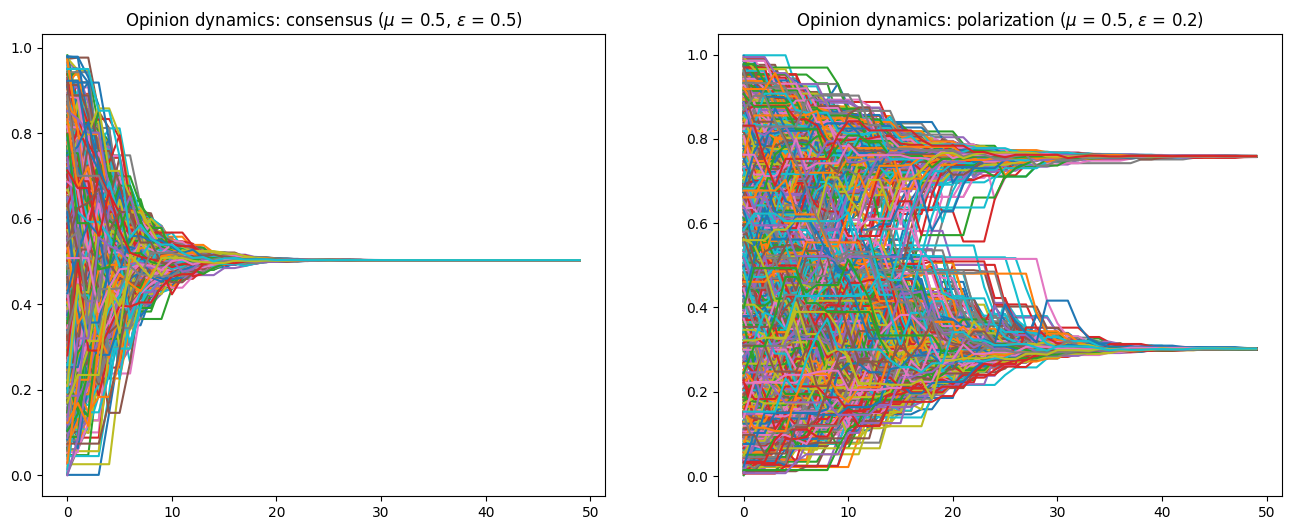

In [240]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(M_2);
axs[0].title.set_text('Opinion dynamics: consensus ($\mu$ = 0.5, $\epsilon$ = 0.5)')
axs[1].plot(M);
axs[1].title.set_text('Opinion dynamics: polarization ($\mu$ = 0.5, $\epsilon$ = 0.2)')

What is interesting to note is that polarization is just consensus reached within distinct clusters of agents: instead, when modeling backfire we are interested in getting away from consensus rather than moving towards it, in a sort of "agree to disagree" fashion. 

Still, bounded confidence is interesting because we have a very simple adaptive mechanism: now we want to make it anthagonistic. 

### From convex combination to non convex combinations: bounded backfire

The idea is to extend the previous model introducing an anthagonistic mechanism if opinions of two interacting agents are far enough: in order to do so, we can consider a simple mechanism. A convex combination between two point $x,y$ in a vector space yields a point $P$ lying in the portion of the line connecting this two points: the equation is just 

$$ P = x + \alpha(y-x), \ \alpha \in [0,1] $$

Clearly we have that 

$$ P \equiv x \iff \alpha = 0 $$
$$ P \equiv y \iff \alpha = 1 $$

This segment in an opinion dynamic perspective can be seen as a *neutral region* where opinions may reach consensus. 

Instead, considering the same equation we have that for $\alpha \in (- \infty, 0) $ the point $P$ lies on the half-line parallel to the one determined by $x$ and $y$ starting from $x$. Viceversa, for $\alpha \in (1, + \infty)$ we have that $P$ lies on the half-line parallel to the one determined by $x$ and $y$ starting from $y$: we can consider these two half-line as *exasperation regions*. It is clear that these parameters yields not anymore a convex combination; indeed, we can leverage this to design a diverging model. 

Given a fully connected network of agent, we consider the following dynamic on a certain number of random interactions: 

$$ x_{i}[t+1] = x_i[t] + \mu (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon) + (\mu - 1) (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| > \eta)$$
$$ x_{j}[t+1] = x_j[t] + \mu (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon) + (\mu - 1) (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| > \eta)$$

Under the assumptions that $ \eta > \epsilon$ and $\mu \in (0,0.5)$, in this model we have that: 
+ If there is agreement $(|x_i[t] - x_j[t]| < \epsilon)$, the dynamic still allows consensus-within-clusters to arise;
+ If there is disagreement $(|x_i[t] - x_j[t]| > \eta)$, the opinions are pushed towards the respective non neutral regions of each agent as we previously defined them.


Let's have a look to a small simulation on a network of ten agents over a small time horizon. 

In [8]:
N = 10
G = nx.complete_graph(N)

x_0 = np.random.uniform(0,1,N)
X = x_0.copy()
eps = 0.2
eta = 0.4
mu = 0.5

T = 10
M = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 1000)]:
        i = e[0]
        j = e[1]
        if np.abs(X[i] - X[j]) < eps:
            x_[i] = X[i] + mu * (X[j] - X[i])
            x_[j] = X[j] + mu * (X[i] - X[j])
        if np.abs(X[i] - X[j]) > eta:
            x_[i] = X[i] + (mu - 1) * (X[j] - X[i])
            x_[j] = X[j] + (mu - 1) * (X[i] - X[j])
    M[_, :] = x_
    X = x_

100%|██████████| 10/10 [00:00<00:00, 131.58it/s]


Text(0.5, 1.0, 'Bounded backfire: divergence of opinions ($\\epsilon$ = 0.2, $\\eta$ = 0.4)')

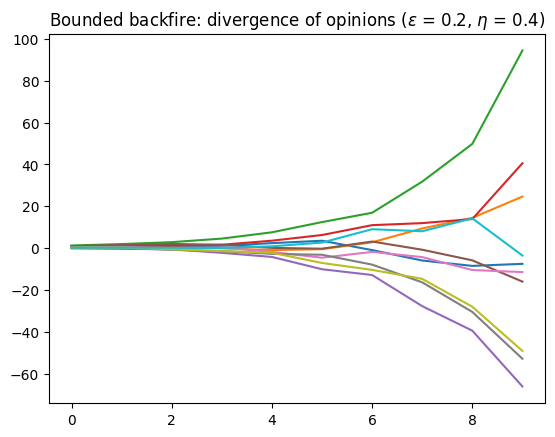

In [11]:
plt.plot(M)
plt.title('Bounded backfire: divergence of opinions ($\epsilon$ = 0.2, $\eta$ = 0.4)')